# Adaptive Construction of Polynomial Chaos Expansions

## Polynomial Chaos Background
Our goal is to approximation a function $f(x)$ using a finite polynomial expansion.  More precisely, we seek an expansion of the form 

$$
\tilde{f}(x) = \sum_{\mathbf{k}\in \mathcal{K}} c_\mathbf{k} \Phi_{\mathbf{k}}(x),
$$

where $\mathbf{k}$ is a multiindex in the set $\mathcal{K}$, $c_\mathbf{k}\in\mathbb{R}$ is a scalar coefficient, and $\Phi_{\mathbf{k}}(x)$ is a multivariate polynomial.  Our goal is to determine the multiindex set $\mathcal{K}$ and the coefficients $c_\mathbf{k}$ to minimize the weighted $L^2$ error of the expansion:

$$
\|\tilde{f}(x) - f(x)\| = \sqrt{\int_\Omega \left(\tilde{f}(x)-f(x)\right)^2 p(x) dx},
$$

where $p(x)$ is a probability density with support $\Omega$.  MUQ adaptively constructs $\tilde{f}(x)$ using the Smolyak pseudo spectral approach of [Conrad and Marzouk, 2012](https://arxiv.org/pdf/1209.1406.pdf).

## Imports

In [1]:
%matplotlib inline

import muq.Modeling as mm
import muq.Utilities as mu
import muq.Approximation as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact
import ipywidgets as widgets 
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from matplotlib.pyplot import cm

import numpy as np
import matplotlib.pyplot as plt

## Define the model
To construct a polynomial chaos expansion with MUQ, we need to first define the model as a child of the `ModPiece` class.   Here, we use a built in `ModPiece` called `CosOperator` that simply returns a componentwise cosine of the input.

In [2]:
dim = 2
model = mm.CosOperator(dim)

## Define the PCE factory

In [3]:
#quad1d = ma.ClenshawCurtisQuadrature()
quad1d = ma.GaussPattersonQuadrature()
polys1d = ma.Legendre()
smolyPCE = ma.AdaptiveSmolyakPCE(model, [quad1d]*dim, [polys1d]*dim);

## Construct the PCE

In [4]:
# Start with a linear approximation
initialOrder = 1
multis = mu.MultiIndexFactory.CreateTotalOrder(dim,initialOrder)

options = dict()
options['ShouldAdapt']  = 1    # After constructing an initial approximation with the terms in "multis", should we continue to adapt?
options['ErrorTol']     = 1e-4 # Stop when the estimated L2 error is below this value
options['MaximumEvals'] = 200   # Stop adapting when more than this many model evaluations has occured

In [5]:
pce = smolyPCE.Compute(multis, options);

In [6]:
print('Number of Model Evaluations:')
print(smolyPCE.NumEvals())

print('\nEstimated L2 Error:')
print('%0.4e'%smolyPCE.Error())

Number of Model Evaluations:
49

Estimated L2 Error:
5.1610e-05


### Plot the convergence diagnostics

In [7]:
errorHist = smolyPCE.ErrorHistory()
evalHist = smolyPCE.EvalHistory()
timeHist = smolyPCE.TimeHistory()

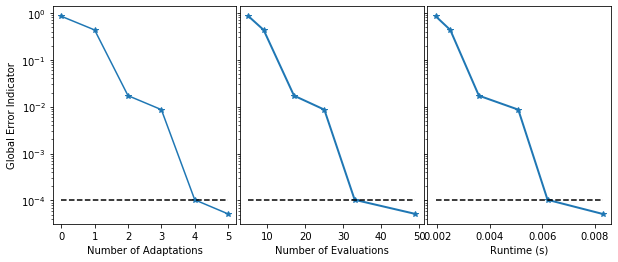

In [8]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(10,4))

axs[0].semilogy(errorHist,'*-')
axs[0].set_ylabel('Global Error Indicator')
axs[0].set_xlabel('Number of Adaptations')
axs[0].semilogy([0, len(errorHist)-1], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[1].semilogy(evalHist, errorHist,'*-',linewidth=2)
axs[1].set_xlabel('Number of Evaluations')
axs[1].semilogy([evalHist[0], evalHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].semilogy(timeHist, errorHist,'*-',linewidth=2)
axs[2].semilogy([timeHist[0], timeHist[-1]], [options['ErrorTol'],options['ErrorTol']],'--k')

axs[2].set_xlabel('Runtime (s)')

plt.subplots_adjust(wspace=0.02)
plt.show()

### Plot the model points and Smolyak terms

In [9]:
ptHist = smolyPCE.PointHistory()
termHist = smolyPCE.TermHistory()

In [10]:
colors=cm.tab20(np.linspace(0,1,len(termHist)))

def PlotAdaptation(AdaptIt):

    fig, axs = plt.subplots(ncols=2,figsize=(11,5))

    for it in range(AdaptIt+1):

        pts_x = [pt[0] for pt in ptHist[it]]
        pts_y = [pt[1] for pt in ptHist[it]]
        axs[0].plot(pts_x,pts_y, '.',markersize=14,color=colors[it])
        
        # Create a Rectangle patch
        boxes=[]
        for term in termHist[it]:
            termVec = term.GetVector()
            boxes.append( patches.Rectangle((termVec[0]-0.5,termVec[1]-0.5),1.0,1.0))

        axs[1].add_collection(PatchCollection(boxes, facecolor=colors[it]))
        
    axs[0].set_xlim([-1.1,1.1])
    axs[0].set_ylim([-1.1,1.1])

    axs[0].set_xlabel('$x_1$')
    axs[0].set_ylabel('$x_1$')
    axs[0].set_title('Evaluation Points (Iteration %d)'%AdaptIt)

    axs[1].set_xlim([-0.5,7.5])
    axs[1].set_ylim([-0.5,7.5])

    axs[1].set_ylabel('Order in $x_1$')
    axs[1].set_ylabel('Order in $x_2$')
    axs[1].set_title('Smolyak Terms (Iteration %d)'%AdaptIt)
    

interact(PlotAdaptation, AdaptIt=widgets.IntSlider(min=0, max=len(ptHist)-1, step=1, value=len(ptHist)-1));


interactive(children=(IntSlider(value=5, description='AdaptIt', max=5), Output()), _dom_classes=('widget-inter…

### Plot the polynoial terms in the PCE

In [11]:
polyTerms = pce.Multis()

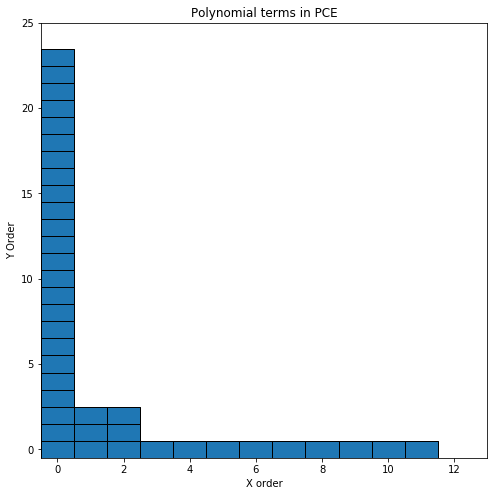

In [12]:
fig = plt.figure(figsize=(8,8))

# A list of rectangular patches.  One for each term
boxes=[]

# Loop over all of the multiindices 
maxOrderX = 0 # 
maxOrderY = 0
for i in range(polyTerms.Size()):
    termVec = polyTerms.at(i).GetVector()
    
    boxes.append( patches.Rectangle((termVec[0]-0.5,termVec[1]-0.5),1.0,1.0))
    
    maxOrderX = np.max([maxOrderX, termVec[0]])
    maxOrderY = np.max([maxOrderY, termVec[1]])

    
plt.gca().add_collection(PatchCollection(boxes,edgecolors='k'))
plt.xlim(-0.5,maxOrderX+2)
plt.ylim(-0.5,maxOrderY+2)

plt.xlabel('X order')
plt.ylabel('Y Order')
plt.title('Polynomial terms in PCE')
plt.show()

## Plot the PCE predictions

Before plotting, we need to evaluate the true model and the PCE surrogate at a grid of points.  These evaluations are completed in the following cell.

In [13]:
numPlot = 50

x = np.linspace(-1,1,numPlot)
X, Y = np.meshgrid(x,x)

trueEvals = np.zeros(X.shape)
pceEvals = np.zeros(X.shape)

for i in range(numPlot):
    for j in range(numPlot):
        pt = [X[i,j],Y[i,j]]
        
        trueEvals[i,j] = model.Evaluate([pt])[0][0]
        pceEvals[i,j] = pce.Evaluate([pt])[0][0]        

The cell below plots the true model evaluations, the PCE evaluations, and the error.  

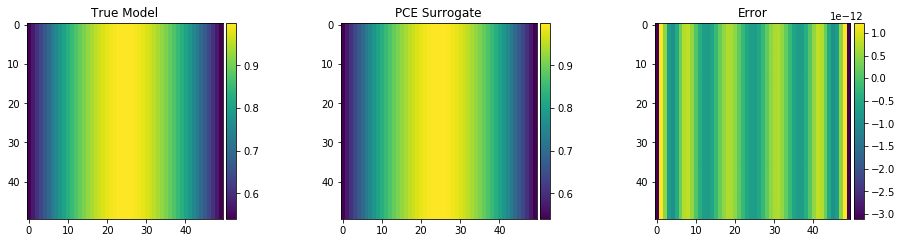

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15,7), gridspec_kw={'wspace':0.5})

# Plot the true model
im = axs[0].imshow(trueEvals)
axs[0].set_title('True Model')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# Plot the PCE Surrogate
im = axs[1].imshow(pceEvals)
axs[1].set_title('PCE Surrogate')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = axs[2].imshow(pceEvals-trueEvals)

axs[2].set_title('Error')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Propagate Uncertainty

In [15]:
print('Prediction Mean:')
print(pce.Mean())

print('\nPrediction Variance:')
print(pce.Variance())

print('\nPrediction Covariance:')
print(pce.Covariance())


Prediction Mean:
[0.84147098 0.84147098]

Prediction Variance:
[0.01925094 0.01925094]

Prediction Covariance:
[[1.92509384e-02 1.09585700e-18]
 [1.09585700e-18 1.92509384e-02]]


## Sensitivity analysis

In [16]:
totalSens1 = pce.TotalSensitivity(0)
totalSens2 = pce.TotalSensitivity(1)

print('Total Sensitivities:')
print('  Output 0 wrt parameter 0 = %0.2e'%totalSens1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%totalSens1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%totalSens2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%totalSens2[1])

print('\nAll Total Sensitivities:')
print(pce.TotalSensitivity())

mainEffects1 = pce.SobolSensitivity(0)
mainEffects2 = pce.SobolSensitivity(1)
print('\nFirst Order Sobol Indices:')
print('  Output 0 wrt parameter 0 = %0.2e'%mainEffects1[0])
print('  Output 0 wrt parameter 1 = %0.2e'%mainEffects1[1])
print('  Output 1 wrt parameter 0 = %0.2e'%mainEffects2[0])
print('  Output 1 wrt parameter 1 = %0.2e'%mainEffects2[1])

Total Sensitivities:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.39e-29
  Output 1 wrt parameter 0 = 1.46e-29
  Output 1 wrt parameter 1 = 1.00e+00

All Total Sensitivities:
[[1.00000000e+00 1.46011825e-29]
 [1.38826284e-29 1.00000000e+00]]

First Order Sobol Indices:
  Output 0 wrt parameter 0 = 1.00e+00
  Output 0 wrt parameter 1 = 1.36e-29
  Output 1 wrt parameter 0 = 1.44e-29
  Output 1 wrt parameter 1 = 1.00e+00
